In [341]:
#importing libraries 
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date,timedelta
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

import seaborn as sns
sns.set(style = 'ticks')

In [137]:
#reading the data from the excel file
customer_ds = pd.read_excel('C:/Users/Jewin/Desktop/Jovita-DataSciene/DATA/Capstone/Online Retail.xlsx')

In [138]:
customer_ds

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2      2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
...                    ...        ...         ...             ...  
541904 2011-12-09 12:50:00       0.85     12680.0          France  
541905 2011-12-09 12:50:00       2.10     12680.0          France  
541906 2011-12-09 12:50:00       4.15     12680.0          France  
541907 2011-12-09 12:50:00       4.15     12680.0          France  
541908 2011-12-09 12:50:00       4.95     12680.0          France  

[541909 rows x 8 columns]

In [139]:
#Considering only customer's from UK , else payment value would differ
customer_ds=customer_ds[customer_ds['Country']=='United Kingdom']


In [140]:
#deleting the columns not required for analysis
customer_ds=customer_ds.drop(columns=['StockCode','Description','Country'])

In [141]:
#quering the null values
print(customer_ds.isnull().sum())

InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
dtype: int64


In [142]:
#deleting the rows with customer id as null
customer_ds=customer_ds[~customer_ds['CustomerID'].isnull()]

In [143]:
#Checking the data types
customer_ds.dtypes

InvoiceNo              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
dtype: object

In [144]:
#Adding an columns to get the payment value (quantity*unit price)
customer_ds['payment_value']=customer_ds['Quantity']*customer_ds['UnitPrice']

In [145]:
customer_ds.describe().T

count          mean          std       min       25%  \
Quantity       361878.0     11.077029   263.129266  -80995.0      2.00   
UnitPrice      361878.0      3.256007    70.654731       0.0      1.25   
CustomerID     361878.0  15547.871368  1594.402590   12346.0  14194.00   
payment_value  361878.0     18.702086   451.918484 -168469.6      3.75   

                    50%       75%       max  
Quantity           4.00     12.00   80995.0  
UnitPrice          1.95      3.75   38970.0  
CustomerID     15514.00  16931.00   18287.0  
payment_value     10.20     17.70  168469.6

In [146]:
#function to calculate recency, frequeny and payment value for each customer
def calculate_RFP(customer_ds):
    #getting the maximum Invoice date in the dataset
    max_date=pd.to_datetime(customer_ds['InvoiceDate'].max(), format=None).to_period('D').to_timestamp()+ timedelta(days=1) 
    #getting the maximum invoice date for each customer (excluding the returned orders) and subtracting from max_date in dataset
    customer=customer_ds[customer_ds["Quantity"] > 0].groupby(["CustomerID"])["InvoiceDate"].max().reset_index()
    #getting the days of customer's recent visit
    customer['Recency']=(max_date-customer['InvoiceDate']).dt.days
    frequency=customer_ds[customer_ds["Quantity"] > 0].groupby(["CustomerID"]).InvoiceNo.nunique().reset_index()
    frequency.columns = ['CustomerID','Frequency']
    customer = pd.merge(customer, frequency, on='CustomerID')
    payment = customer_ds.groupby('CustomerID').payment_value.sum().reset_index()
    payment.columns = ['CustomerID','Payment']
    customer = pd.merge(customer, payment, on='CustomerID')
    return customer

In [147]:
#Function call to calculate recency , frequency and payment value for each customer
customer=calculate_RFP(customer_ds)

In [148]:
customer.head()

CustomerID         InvoiceDate  Recency  Frequency   Payment
0     12346.0 2011-01-18 10:01:00      325          1      0.00
1     12747.0 2011-12-07 14:34:00        2         11   4196.01
2     12748.0 2011-12-09 12:20:00        0        210  29072.10
3     12749.0 2011-12-06 09:56:00        3          5   3868.20
4     12820.0 2011-12-06 15:12:00        3          4    942.34

In [149]:
customer.describe()

CustomerID      Recency    Frequency        Payment
count   3921.000000  3921.000000  3921.000000    3921.000000
mean   15561.471563    91.722265     4.246111    1728.365007
std     1576.823683    99.528532     7.205750    6570.071115
min    12346.000000     0.000000     1.000000   -1165.300000
25%    14208.000000    17.000000     1.000000     289.820000
50%    15569.000000    50.000000     2.000000     633.660000
75%    16913.000000   142.000000     5.000000    1530.750000
max    18287.000000   373.000000   210.000000  256438.490000

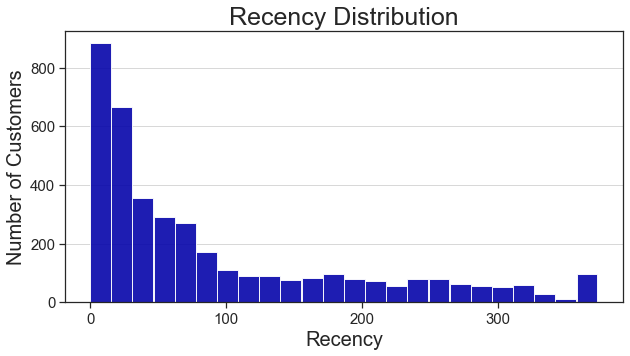

In [150]:
plt.figure(figsize=(10,5))
plt.hist(x=customer['Recency'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Recency Distribution',fontsize=25)
plt.xlabel('Recency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)


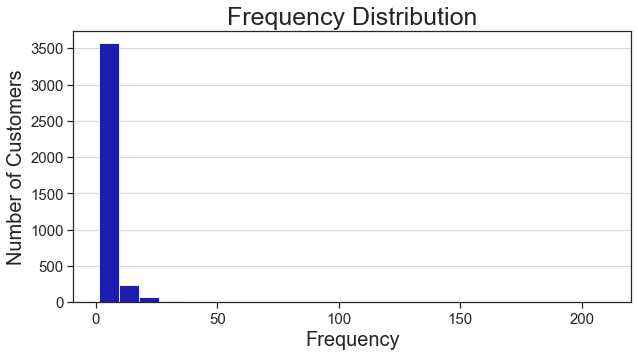

In [151]:
plt.figure(figsize=(10,5))
plt.hist(x=customer['Frequency'], bins=25, color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Frequency Distribution',fontsize=25)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)


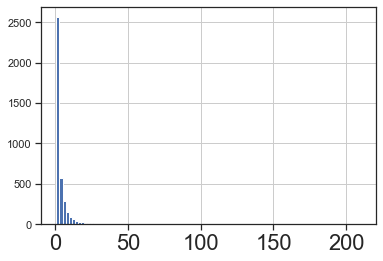

In [152]:
customer['Frequency'].hist(bins=100)

(array([12000., 13000., 14000., 15000., 16000., 17000., 18000., 19000.]),
 <a list of 8 Text yticklabel objects>)

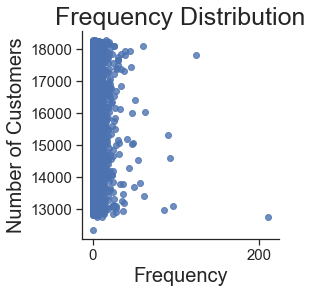

In [153]:
sns.lmplot(x='Frequency', y='CustomerID', data=customer, 
           fit_reg=False)
plt.title('Frequency Distribution',fontsize=25)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

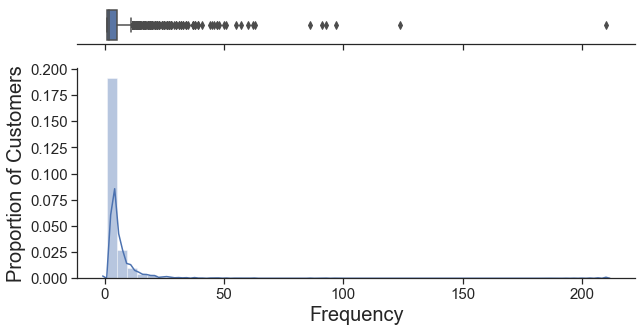

In [154]:
fig, ax = plt.subplots(2, 
                           figsize = (10, 5),
                           sharex = True, 
                           gridspec_kw = {'height_ratios': (0.15, 0.85)})

ax_box = ax[0]
ax_box = sns.boxplot(customer['Frequency'], ax = ax_box)
ax_box.set(title = '', yticks = [], xlabel = '')
sns.despine(ax = ax_box, left = True)

ax_hist = ax[1]
ax_hist = sns.distplot(customer['Frequency'], ax = ax_hist)
ax_hist.set(xlabel = 'Frequency')
sns.despine(ax = ax_hist)

plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Proportion of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

(array([12000., 13000., 14000., 15000., 16000., 17000., 18000., 19000.]),
 <a list of 8 Text yticklabel objects>)

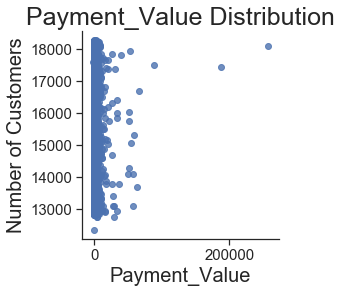

In [155]:
sns.lmplot(x='Payment', y='CustomerID', data=customer, 
           fit_reg=False)
plt.title('Payment_Value Distribution',fontsize=25)
plt.xlabel('Payment_Value',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

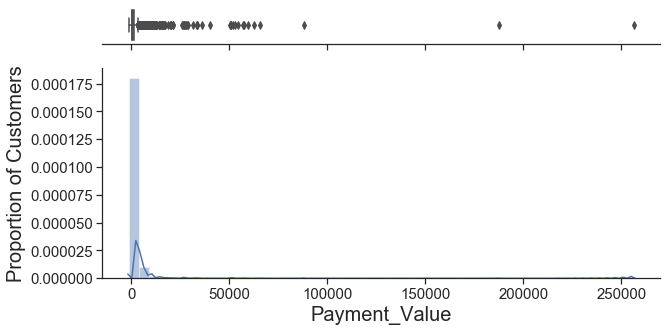

In [156]:
fig, ax = plt.subplots(2, 
                           figsize = (10, 5),
                           sharex = True, 
                           gridspec_kw = {'height_ratios': (0.15, 0.85)})

ax_box = ax[0]
ax_box = sns.boxplot(customer['Payment'], ax = ax_box)
ax_box.set(title = '', yticks = [], xlabel = '')
sns.despine(ax = ax_box, left = True)

ax_hist = ax[1]
ax_hist = sns.distplot(customer['Payment'], ax = ax_hist)
ax_hist.set(xlabel = 'Payment_Value')
sns.despine(ax = ax_hist)

plt.xlabel('Payment_Value',fontsize=20)
plt.ylabel('Proportion of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [164]:
plot_payment=customer[customer['Payment']<10000]

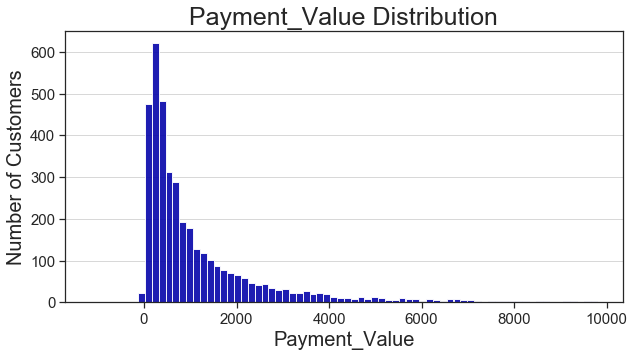

In [166]:
#Plotting the graph for payment value lesser than 10,000 for better visualization 

plt.figure(figsize=(10,5))
plt.hist(x=plot_payment['Payment'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Payment_Value Distribution',fontsize=25)
plt.xlabel('Payment_Value',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

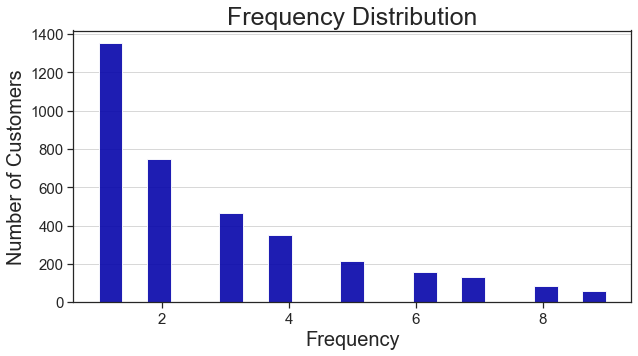

In [168]:
#Plotting the graph for payment value lesser than 10 for better visualization 

plot_frequency=customer[customer['Frequency']<10]
plt.figure(figsize=(10,5))
plt.hist(x=plot_frequency['Frequency'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Frequency Distribution',fontsize=25)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [169]:
customer.corr()

CustomerID   Recency  Frequency   Payment
CustomerID    1.000000  0.008299  -0.020160  0.007221
Recency       0.008299  1.000000  -0.273779 -0.146529
Frequency    -0.020160 -0.273779   1.000000  0.553537
Payment       0.007221 -0.146529   0.553537  1.000000

(6.0, 0)

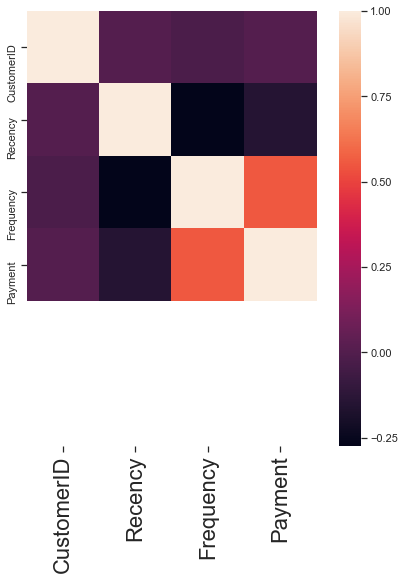

In [171]:
plt.figure(figsize=(8,8))
ax=sns.heatmap(customer.corr(),square = True)
ax.set_ylim(6.0, 0)

(array([-250000.,       0.,  250000.,  500000.]),
 <a list of 0 Text xticklabel objects>)

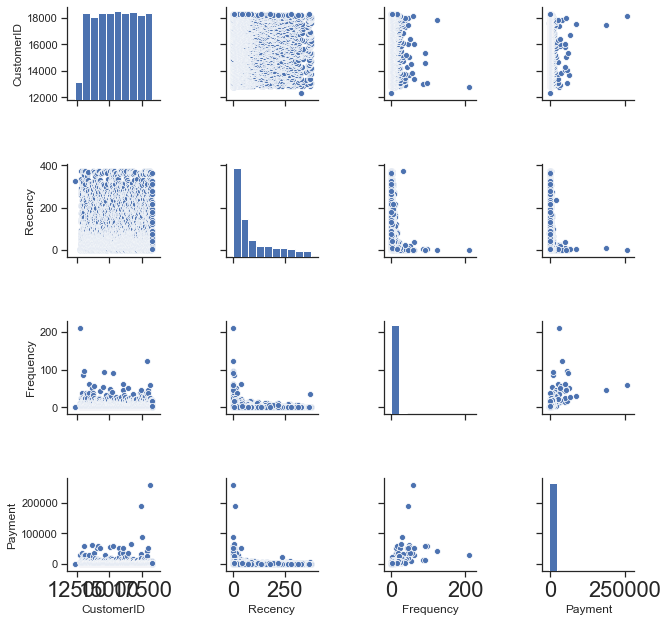

In [173]:
sns.pairplot(customer)
plt.xticks(fontsize=5)

In [174]:
#Coverting the recency from number of days to a ordered ranking number
customer['Recency_RANK']=customer['Recency'].rank(method='max')
customer['PCNT_RANK']=customer['Recency'].rank(method='max', pct=True)
customer['Ordered_Recency_Per']=1-customer['PCNT_RANK']

In [176]:
customer.head()

CustomerID         InvoiceDate  Recency  Frequency   Payment  Recency_RANK  \
0     12346.0 2011-01-18 10:01:00      325          1      0.00        3781.0   
1     12747.0 2011-12-07 14:34:00        2         11   4196.01         208.0   
2     12748.0 2011-12-09 12:20:00        0        210  29072.10          28.0   
3     12749.0 2011-12-06 09:56:00        3          5   3868.20         292.0   
4     12820.0 2011-12-06 15:12:00        3          4    942.34         292.0   

   PCNT_RANK  Ordered_Recency_Per  
0   0.964295             0.035705  
1   0.053048             0.946952  
2   0.007141             0.992859  
3   0.074471             0.925529  
4   0.074471             0.925529

In [177]:
#Coverting the frequency and payment value from number of days and currency value to a ordered ranking number
customer['Frequency_RANK']=customer['Frequency'].rank(method='max', pct=True)
customer['Payement_RANK']=customer['Payment'].rank(method='max', pct=True)

In [178]:
#Taking average of the 3 to rank the total for each customer
customer['Total_Rank']=(customer['Frequency_RANK']+customer['Payement_RANK']+customer['Ordered_Recency_Per'])/3

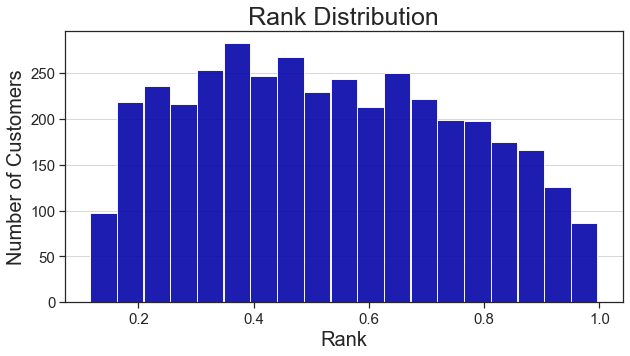

In [180]:
#customer['Total_Rank'].hist(bins=10, figsize=[14,6])
plt.figure(figsize=(10,5))
plt.hist(x=customer['Total_Rank'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Rank Distribution',fontsize=25)
plt.xlabel('Rank',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [181]:
customer['CLTV']=pd.cut(customer.Total_Rank, bins=4, labels=np.arange(4), right=False)

In [182]:
customer.head()

CustomerID         InvoiceDate  Recency  Frequency   Payment  Recency_RANK  \
0     12346.0 2011-01-18 10:01:00      325          1      0.00        3781.0   
1     12747.0 2011-12-07 14:34:00        2         11   4196.01         208.0   
2     12748.0 2011-12-09 12:20:00        0        210  29072.10          28.0   
3     12749.0 2011-12-06 09:56:00        3          5   3868.20         292.0   
4     12820.0 2011-12-06 15:12:00        3          4    942.34         292.0   

   PCNT_RANK  Ordered_Recency_Per  Frequency_RANK  Payement_RANK  Total_Rank  \
0   0.964295             0.035705        0.344555       0.004081    0.128114   
1   0.053048             0.946952        0.933435       0.930630    0.937006   
2   0.007141             0.992859        1.000000       0.994644    0.995834   
3   0.074471             0.925529        0.798266       0.922214    0.882003   
4   0.074471             0.925529        0.742923       0.621270    0.763241   

  CLTV  
0    0  
1    3  
2    3  
3    3  
4    2

In [183]:
df=customer[['CustomerID','Ordered_Recency_Per','Frequency_RANK','Payement_RANK']]
Xs = normalize(df)

In [184]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Xs)
    Sum_of_squared_distances.append(km.inertia_)

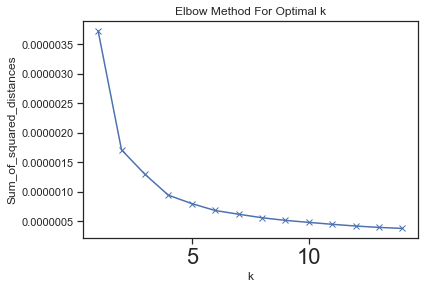

In [185]:
#Code to get the optimal value for k
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [186]:
k = 4
# 4 Clusters
k_mean2 = KMeans(n_clusters=k)
k_mean2.fit(Xs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [187]:
customer['Cluster'] = k_mean2.labels_

In [188]:
customer

CustomerID         InvoiceDate  Recency  Frequency   Payment  \
0        12346.0 2011-01-18 10:01:00      325          1      0.00   
1        12747.0 2011-12-07 14:34:00        2         11   4196.01   
2        12748.0 2011-12-09 12:20:00        0        210  29072.10   
3        12749.0 2011-12-06 09:56:00        3          5   3868.20   
4        12820.0 2011-12-06 15:12:00        3          4    942.34   
...          ...                 ...      ...        ...       ...   
3916     18280.0 2011-03-07 09:52:00      277          1    180.60   
3917     18281.0 2011-06-12 10:53:00      180          1     80.82   
3918     18282.0 2011-12-02 11:43:00        7          2    176.60   
3919     18283.0 2011-12-06 12:02:00        3         16   2094.88   
3920     18287.0 2011-10-28 09:29:00       42          3   1837.28   

      Recency_RANK  PCNT_RANK  Ordered_Recency_Per  Frequency_RANK  \
0           3781.0   0.964295             0.035705        0.344555   
1            208.0   0.053048             0.946952        0.933435   
2             28.0   0.007141             0.992859        1.000000   
3            292.0   0.074471             0.925529        0.798266   
4            292.0   0.074471             0.925529        0.742923   
...            ...        ...                  ...             ...   
3916        3617.0   0.922469             0.077531        0.344555   
3917        3148.0   0.802856             0.197144        0.344555   
3918         485.0   0.123693             0.876307        0.534813   
3919         292.0   0.074471             0.925529        0.964805   
3920        1801.0   0.459322             0.540678        0.653405   

      Payement_RANK  Total_Rank CLTV  Cluster  
0          0.004081    0.128114    0        0  
1          0.930630    0.937006    3        3  
2          0.994644    0.995834    3        3  
3          0.922214    0.882003    3        3  
4          0.621270    0.763241    2        3  
...             ...         ...  ...      ...  
3916       0.141801    0.187962    0        0  
3917       0.030604    0.190768    0        0  
3918       0.135680    0.515600    1        1  
3919       0.820199    0.903511    3        3  
3920       0.790360    0.661481    2        2  

[3921 rows x 13 columns]

In [189]:
customer['Cluster'].value_counts()

0    1136
3    1041
2     944
1     800
Name: Cluster, dtype: int64

In [190]:
customer['CLTV'].value_counts()

1    1224
2    1040
0     956
3     701
Name: CLTV, dtype: int64

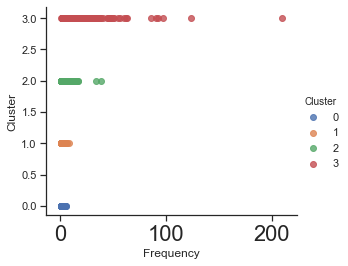

In [192]:
sns.lmplot(x='Frequency', y='Cluster', data=customer, hue='Cluster', 
           fit_reg=False)

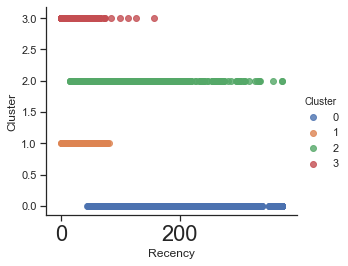

In [193]:
sns.lmplot(x='Recency', y='Cluster', data=customer, hue='Cluster', 
           fit_reg=False)

In [207]:
plot_frequency=customer[customer['Payment']<5000]

<Figure size 1440x720 with 0 Axes>

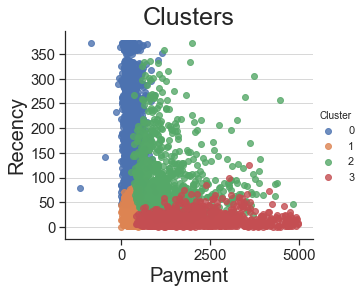

In [211]:
plt.figure(figsize=(20,10))
sns.lmplot(x='Payment', y='Recency', data=plot_frequency, hue='Cluster', fit_reg=False)
plt.title('Clusters',fontsize=25)
plt.xlabel('Payment',fontsize=20)
plt.ylabel('Recency',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [246]:
filter1=customer['Recency']<200
filter2=customer['Frequency']<40
plot_frequency=customer[filter1 & filter2]
#plot_frequency=customer
#plot_frequency=customer[customer['Frequency']<30]

<Figure size 2160x1440 with 0 Axes>

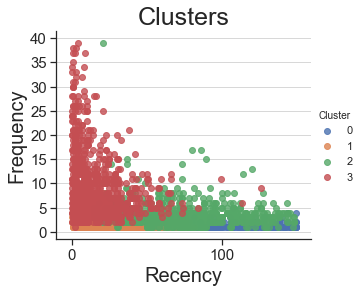

In [245]:
plt.figure(figsize=(30,20))
sns.lmplot(x='Recency', y='Frequency', data=plot_frequency, hue='Cluster', fit_reg=False)
plt.title('Clusters',fontsize=25)
plt.xlabel('Recency',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)
#plt.legend(loc='center right', labels=['Hell Yeh', 'Nah Bruh'])
plt.show()

In [202]:
cust_display=customer
cust_display=cust_display.drop(columns=['CustomerID','InvoiceDate','Recency_RANK','PCNT_RANK','Ordered_Recency_Per','Frequency_RANK','Payement_RANK','Total_Rank','CLTV'])

(array([-2.5,  0. ,  2.5,  5. ]), <a list of 0 Text xticklabel objects>)

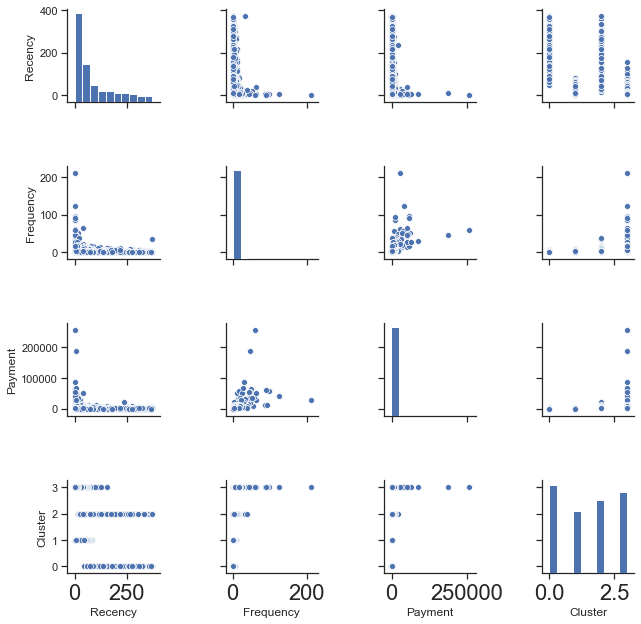

In [203]:
sns.pairplot(cust_display)
plt.xticks(fontsize=5)

# Predicting next purchase date

In [250]:
Final_end=pd.to_datetime(customer_ds['InvoiceDate'].max(), format=None).to_period('D').to_timestamp()
start_date=pd.to_datetime(customer_ds['InvoiceDate'].min(), format=None).to_period('D').to_timestamp()
split_date=date(2011,8,1)
end_date=date(2011,11,1)

In [251]:
customer_ds

InvoiceNo  Quantity         InvoiceDate  UnitPrice  CustomerID  \
0         536365         6 2010-12-01 08:26:00       2.55     17850.0   
1         536365         6 2010-12-01 08:26:00       3.39     17850.0   
2         536365         8 2010-12-01 08:26:00       2.75     17850.0   
3         536365         6 2010-12-01 08:26:00       3.39     17850.0   
4         536365         6 2010-12-01 08:26:00       3.39     17850.0   
...          ...       ...                 ...        ...         ...   
541889    581585        12 2011-12-09 12:31:00       1.95     15804.0   
541890    581586         8 2011-12-09 12:49:00       2.95     13113.0   
541891    581586        24 2011-12-09 12:49:00       1.25     13113.0   
541892    581586        24 2011-12-09 12:49:00       8.95     13113.0   
541893    581586        10 2011-12-09 12:49:00       7.08     13113.0   

        payment_value  
0               15.30  
1               20.34  
2               22.00  
3               20.34  
4               20.34  
...               ...  
541889          23.40  
541890          23.60  
541891          30.00  
541892         214.80  
541893          70.80  

[361878 rows x 6 columns]

In [252]:
training_period=customer_ds.loc[(customer_ds.InvoiceDate >= start_date) & (customer_ds.InvoiceDate <= split_date)]
testing_period=customer_ds.loc[(customer_ds.InvoiceDate > split_date) & (customer_ds.InvoiceDate <= end_date)]

D:\DataScience\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
D:\DataScience\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [253]:
data=pd.DataFrame(training_period['CustomerID'].unique())
data.columns = ['CustomerID']

In [254]:
#first purchase in testing period
testing_period_first_purchase = testing_period[testing_period["Quantity"] > 0].groupby('CustomerID').InvoiceDate.min().reset_index()
#testing_period_first_purchase = testing_period.groupby('CustomerID').InvoiceDate.min().reset_index()
testing_period_first_purchase.columns = ['CustomerID','MinPurchaseDate']

#Last purchase date in training period
training_period_last_purchase = training_period[training_period["Quantity"] > 0].groupby('CustomerID').InvoiceDate.max().reset_index()
#training_period_last_purchase = training_period.groupby('CustomerID').InvoiceDate.max().reset_index()
training_period_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [255]:
testing_period_first_purchase

CustomerID     MinPurchaseDate
0        12747.0 2011-08-22 10:38:00
1        12748.0 2011-08-03 12:20:00
2        12749.0 2011-08-01 12:48:00
3        12820.0 2011-09-26 11:49:00
4        12822.0 2011-09-13 13:46:00
...          ...                 ...
2227     18277.0 2011-10-12 15:22:00
2228     18278.0 2011-09-27 11:58:00
2229     18282.0 2011-08-05 13:35:00
2230     18283.0 2011-09-05 12:35:00
2231     18287.0 2011-10-12 10:23:00

[2232 rows x 2 columns]

In [256]:
training_period_last_purchase

CustomerID     MaxPurchaseDate
0        12346.0 2011-01-18 10:01:00
1        12747.0 2011-06-28 10:06:00
2        12748.0 2011-07-31 15:04:00
3        12749.0 2011-05-10 15:25:00
4        12820.0 2011-01-17 12:34:00
...          ...                 ...
2843     18273.0 2011-03-27 11:22:00
2844     18280.0 2011-03-07 09:52:00
2845     18281.0 2011-06-12 10:53:00
2846     18283.0 2011-07-14 13:20:00
2847     18287.0 2011-05-22 10:39:00

[2848 rows x 2 columns]

In [257]:
train_test_merge=pd.merge(training_period_last_purchase,testing_period_first_purchase,on='CustomerID',how='left')

In [258]:
train_test_merge

CustomerID     MaxPurchaseDate     MinPurchaseDate
0        12346.0 2011-01-18 10:01:00                 NaT
1        12747.0 2011-06-28 10:06:00 2011-08-22 10:38:00
2        12748.0 2011-07-31 15:04:00 2011-08-03 12:20:00
3        12749.0 2011-05-10 15:25:00 2011-08-01 12:48:00
4        12820.0 2011-01-17 12:34:00 2011-09-26 11:49:00
...          ...                 ...                 ...
2843     18273.0 2011-03-27 11:22:00 2011-09-05 11:27:00
2844     18280.0 2011-03-07 09:52:00                 NaT
2845     18281.0 2011-06-12 10:53:00                 NaT
2846     18283.0 2011-07-14 13:20:00 2011-09-05 12:35:00
2847     18287.0 2011-05-22 10:39:00 2011-10-12 10:23:00

[2848 rows x 3 columns]

In [259]:
train_test_merge['NextPurchaseDay_TestPeriod'] = (train_test_merge['MinPurchaseDate'] - train_test_merge['MaxPurchaseDate']).dt.days
data=pd.merge(data, train_test_merge[['CustomerID','NextPurchaseDay_TestPeriod']],on='CustomerID',how='left')

In [260]:
data
#NaN means they do not have a purchase date in that period . 
#for analysis we could consider it as a large next purchase date and fill that number by 999

CustomerID  NextPurchaseDay_TestPeriod
0        17850.0                         NaN
1        13047.0                        46.0
2        13748.0                       136.0
3        15100.0                         NaN
4        15291.0                        77.0
...          ...                         ...
2882     13928.0                        26.0
2883     14885.0                         NaN
2884     13388.0                         NaN
2885     15438.0                         NaN
2886     17173.0                        14.0

[2887 rows x 2 columns]

In [261]:
data = data.fillna(999)

In [263]:
df_Invoice_Day = training_period[['CustomerID','InvoiceDate']]
df_Invoice_Day['InvoiceDay'] = training_period['InvoiceDate'].dt.date

D:\DataScience\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [264]:
df_Invoice_Day

CustomerID         InvoiceDate  InvoiceDay
0          17850.0 2010-12-01 08:26:00  2010-12-01
1          17850.0 2010-12-01 08:26:00  2010-12-01
2          17850.0 2010-12-01 08:26:00  2010-12-01
3          17850.0 2010-12-01 08:26:00  2010-12-01
4          17850.0 2010-12-01 08:26:00  2010-12-01
...            ...                 ...         ...
285416     17162.0 2011-07-31 16:04:00  2011-07-31
285417     17162.0 2011-07-31 16:04:00  2011-07-31
285418     17162.0 2011-07-31 16:04:00  2011-07-31
285419     17162.0 2011-07-31 16:04:00  2011-07-31
285420     17162.0 2011-07-31 16:04:00  2011-07-31

[181533 rows x 3 columns]

In [265]:
#drop duplicates
df_Invoice_Day = df_Invoice_Day.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [266]:
#shifting last 3 purchase dates
df_Invoice_Day['n-1'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(1)
df_Invoice_Day['n-2'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(2)
df_Invoice_Day['n-3'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(3)

D:\DataScience\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\DataScience\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\DataScience\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [267]:
df_Invoice_Day

CustomerID         InvoiceDate  InvoiceDay         n-1         n-2  \
0          17850.0 2010-12-01 08:26:00  2010-12-01         NaN         NaN   
9          13047.0 2010-12-01 08:34:00  2010-12-01         NaN         NaN   
46         13748.0 2010-12-01 09:00:00  2010-12-01         NaN         NaN   
65         15100.0 2010-12-01 09:09:00  2010-12-01         NaN         NaN   
82         15291.0 2010-12-01 09:32:00  2010-12-01         NaN         NaN   
...            ...                 ...         ...         ...         ...   
285140     15819.0 2011-07-31 15:22:00  2011-07-31  2011-05-24  2011-03-08   
285164     17841.0 2011-07-31 15:24:00  2011-07-31  2011-07-29  2011-07-27   
285268     17173.0 2011-07-31 15:26:00  2011-07-31         NaN         NaN   
285280     16655.0 2011-07-31 15:31:00  2011-07-31  2011-06-07  2011-01-12   
285404     17162.0 2011-07-31 16:04:00  2011-07-31  2011-06-07  2011-06-02   

               n-3  
0              NaN  
9              NaN  
46             NaN  
65             NaN  
82             NaN  
...            ...  
285140         NaN  
285164  2011-07-25  
285268         NaN  
285280         NaN  
285404  2011-04-08  

[9614 rows x 6 columns]

In [275]:
df_Invoice_Day['DayDiff1'] = (df_Invoice_Day['InvoiceDay'] - df_Invoice_Day['n-1']).dt.days
df_Invoice_Day['DayDiff2'] = (df_Invoice_Day['n-1'] - df_Invoice_Day['n-2']).dt.days
df_Invoice_Day['DayDiff3'] = (df_Invoice_Day['n-2'] - df_Invoice_Day['n-3']).dt.days

D:\DataScience\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\DataScience\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\DataScience\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [276]:
df_Invoice_Day

CustomerID         InvoiceDate  InvoiceDay         n-1         n-2  \
0          17850.0 2010-12-01 08:26:00  2010-12-01         NaN         NaN   
9          13047.0 2010-12-01 08:34:00  2010-12-01         NaN         NaN   
46         13748.0 2010-12-01 09:00:00  2010-12-01         NaN         NaN   
65         15100.0 2010-12-01 09:09:00  2010-12-01         NaN         NaN   
82         15291.0 2010-12-01 09:32:00  2010-12-01         NaN         NaN   
...            ...                 ...         ...         ...         ...   
285140     15819.0 2011-07-31 15:22:00  2011-07-31  2011-05-24  2011-03-08   
285164     17841.0 2011-07-31 15:24:00  2011-07-31  2011-07-29  2011-07-27   
285268     17173.0 2011-07-31 15:26:00  2011-07-31         NaN         NaN   
285280     16655.0 2011-07-31 15:31:00  2011-07-31  2011-06-07  2011-01-12   
285404     17162.0 2011-07-31 16:04:00  2011-07-31  2011-06-07  2011-06-02   

               n-3  DayDiff1  DayDiff2  DayDiff3  
0              NaN       NaN       NaN       NaN  
9              NaN       NaN       NaN       NaN  
46             NaN       NaN       NaN       NaN  
65             NaN       NaN       NaN       NaN  
82             NaN       NaN       NaN       NaN  
...            ...       ...       ...       ...  
285140         NaN      68.0      77.0       NaN  
285164  2011-07-25       2.0       2.0       2.0  
285268         NaN       NaN       NaN       NaN  
285280         NaN      54.0     146.0       NaN  
285404  2011-04-08      54.0       5.0      55.0  

[9614 rows x 9 columns]

In [277]:
day_order_last = df_Invoice_Day.drop_duplicates(subset=['CustomerID'],keep='last')

In [278]:
day_order_last = day_order_last.dropna()

In [279]:
day_order_last

CustomerID         InvoiceDate  InvoiceDay         n-1         n-2  \
56833      15100.0 2011-01-13 17:09:00  2011-01-13  2011-01-10  2010-12-16   
57220      16233.0 2011-01-14 10:31:00  2011-01-14  2010-12-16  2010-12-14   
73784      14299.0 2011-01-27 14:26:00  2011-01-27  2011-01-25  2011-01-14   
75476      17062.0 2011-01-30 11:01:00  2011-01-30  2010-12-16  2010-12-09   
78905      15107.0 2011-02-01 14:46:00  2011-02-01  2011-01-13  2011-01-11   
...            ...                 ...         ...         ...         ...   
284783     14414.0 2011-07-31 13:33:00  2011-07-31  2011-07-29  2011-07-26   
284804     14092.0 2011-07-31 13:36:00  2011-07-31  2011-06-22  2011-05-27   
285139     12748.0 2011-07-31 15:04:00  2011-07-31  2011-07-29  2011-07-28   
285164     17841.0 2011-07-31 15:24:00  2011-07-31  2011-07-29  2011-07-27   
285404     17162.0 2011-07-31 16:04:00  2011-07-31  2011-06-07  2011-06-02   

               n-3  DayDiff1  DayDiff2  DayDiff3  
56833   2010-12-08       3.0      25.0       8.0  
57220   2010-12-08      29.0       2.0       6.0  
73784   2011-01-13       2.0      11.0       1.0  
75476   2010-12-05      45.0       7.0       4.0  
78905   2011-01-09      19.0       2.0       2.0  
...            ...       ...       ...       ...  
284783  2010-12-16       2.0       3.0     222.0  
284804  2011-04-17      39.0      26.0      40.0  
285139  2011-07-21       2.0       1.0       7.0  
285164  2011-07-25       2.0       2.0       2.0  
285404  2011-04-08      54.0       5.0      55.0  

[777 rows x 9 columns]

In [280]:
data = pd.merge(data, day_order_last[['CustomerID','InvoiceDay','DayDiff1','DayDiff2','DayDiff3']], on='CustomerID')

In [281]:
data

CustomerID  NextPurchaseDay_TestPeriod  InvoiceDay  DayDiff1  DayDiff2  \
0       13047.0                        46.0  2011-07-08      19.0       4.0   
1       15100.0                       999.0  2011-01-13       3.0      25.0   
2       15291.0                        77.0  2011-06-20       8.0      67.0   
3       14688.0                        12.0  2011-07-21       9.0      14.0   
4       17809.0                        43.0  2011-07-18      24.0       4.0   
..          ...                         ...         ...       ...       ...   
772     17651.0                        76.0  2011-07-19      12.0      14.0   
773     14808.0                        69.0  2011-07-18       8.0      14.0   
774     12830.0                        42.0  2011-07-28       7.0      15.0   
775     13420.0                       999.0  2011-07-28      15.0       7.0   
776     17997.0                        34.0  2011-07-29      19.0       4.0   

     DayDiff3  
0        42.0  
1         8.0  
2         5.0  
3        15.0  
4        45.0  
..        ...  
772       3.0  
773       6.0  
774      15.0  
775      14.0  
776       8.0  

[777 rows x 6 columns]

(array([ 9., 19., 19., 34., 29., 34., 32., 26., 32., 20., 29., 28., 24.,
        28., 18., 10., 20., 19., 13., 20., 24.,  9., 16., 19., 11.,  4.,
        12., 12., 11.,  7.,  7.,  9.,  5.,  2.,  3.,  5.,  4.,  1.,  1.,
         0.,  4.,  3.,  1.,  0.,  2.,  3.,  0.,  1.,  0.,  1.]),
 array([  1.  ,   4.96,   8.92,  12.88,  16.84,  20.8 ,  24.76,  28.72,
         32.68,  36.64,  40.6 ,  44.56,  48.52,  52.48,  56.44,  60.4 ,
         64.36,  68.32,  72.28,  76.24,  80.2 ,  84.16,  88.12,  92.08,
         96.04, 100.  , 103.96, 107.92, 111.88, 115.84, 119.8 , 123.76,
        127.72, 131.68, 135.64, 139.6 , 143.56, 147.52, 151.48, 155.44,
        159.4 , 163.36, 167.32, 171.28, 175.24, 179.2 , 183.16, 187.12,
        191.08, 195.04, 199.  ]),
 <a list of 50 Patch objects>)

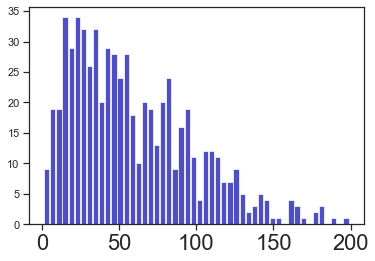

In [287]:
plot_data=data[data['NextPurchaseDay_TestPeriod']<200]
plt.hist(x=plot_data['NextPurchaseDay_TestPeriod'], bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85)

In [304]:
data['NextPurchaseDayRange'] = 0
data.loc[data.NextPurchaseDay_TestPeriod>30,'NextPurchaseDayRange'] = 1
data.loc[data.NextPurchaseDay_TestPeriod>70,'NextPurchaseDayRange'] = 2
data.loc[data.NextPurchaseDay_TestPeriod>150,'NextPurchaseDayRange'] = 3


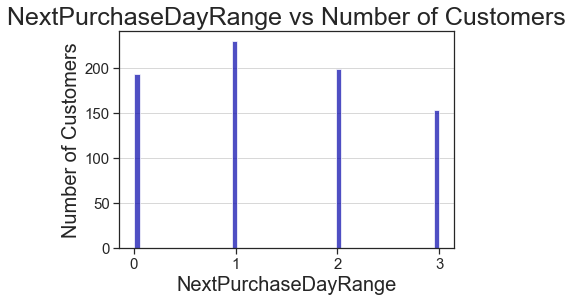

In [305]:
plt.hist(x=data['NextPurchaseDayRange'], bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.title('NextPurchaseDayRange vs Number of Customers',fontsize=25)
plt.xlabel('NextPurchaseDayRange',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [306]:
data

CustomerID  NextPurchaseDay_TestPeriod  InvoiceDay  DayDiff1  DayDiff2  \
0       13047.0                        46.0  2011-07-08      19.0       4.0   
1       15100.0                       999.0  2011-01-13       3.0      25.0   
2       15291.0                        77.0  2011-06-20       8.0      67.0   
3       14688.0                        12.0  2011-07-21       9.0      14.0   
4       17809.0                        43.0  2011-07-18      24.0       4.0   
..          ...                         ...         ...       ...       ...   
772     17651.0                        76.0  2011-07-19      12.0      14.0   
773     14808.0                        69.0  2011-07-18       8.0      14.0   
774     12830.0                        42.0  2011-07-28       7.0      15.0   
775     13420.0                       999.0  2011-07-28      15.0       7.0   
776     17997.0                        34.0  2011-07-29      19.0       4.0   

     DayDiff3  NextPurchaseDayRange  
0        42.0                     1  
1         8.0                     3  
2         5.0                     2  
3        15.0                     0  
4        45.0                     1  
..        ...                   ...  
772       3.0                     2  
773       6.0                     1  
774      15.0                     1  
775      14.0                     3  
776       8.0                     1  

[777 rows x 7 columns]

In [307]:
data['NextPurchaseDayRange'].value_counts()

1    230
2    199
0    194
3    154
Name: NextPurchaseDayRange, dtype: int64

In [308]:
data.corr()

CustomerID  NextPurchaseDay_TestPeriod  DayDiff1  \
CustomerID                    1.000000                    0.040046  0.000306   
NextPurchaseDay_TestPeriod    0.040046                    1.000000  0.108981   
DayDiff1                      0.000306                    0.108981  1.000000   
DayDiff2                      0.029387                    0.019571 -0.017712   
DayDiff3                      0.034607                    0.002551  0.104982   
NextPurchaseDayRange          0.039211                    0.744695  0.179412   

                            DayDiff2  DayDiff3  NextPurchaseDayRange  
CustomerID                  0.029387  0.034607              0.039211  
NextPurchaseDay_TestPeriod  0.019571  0.002551              0.744695  
DayDiff1                   -0.017712  0.104982              0.179412  
DayDiff2                    1.000000  0.000720              0.174119  
DayDiff3                    0.000720  1.000000              0.078695  
NextPurchaseDayRange        0.174119  0.078695              1.000000

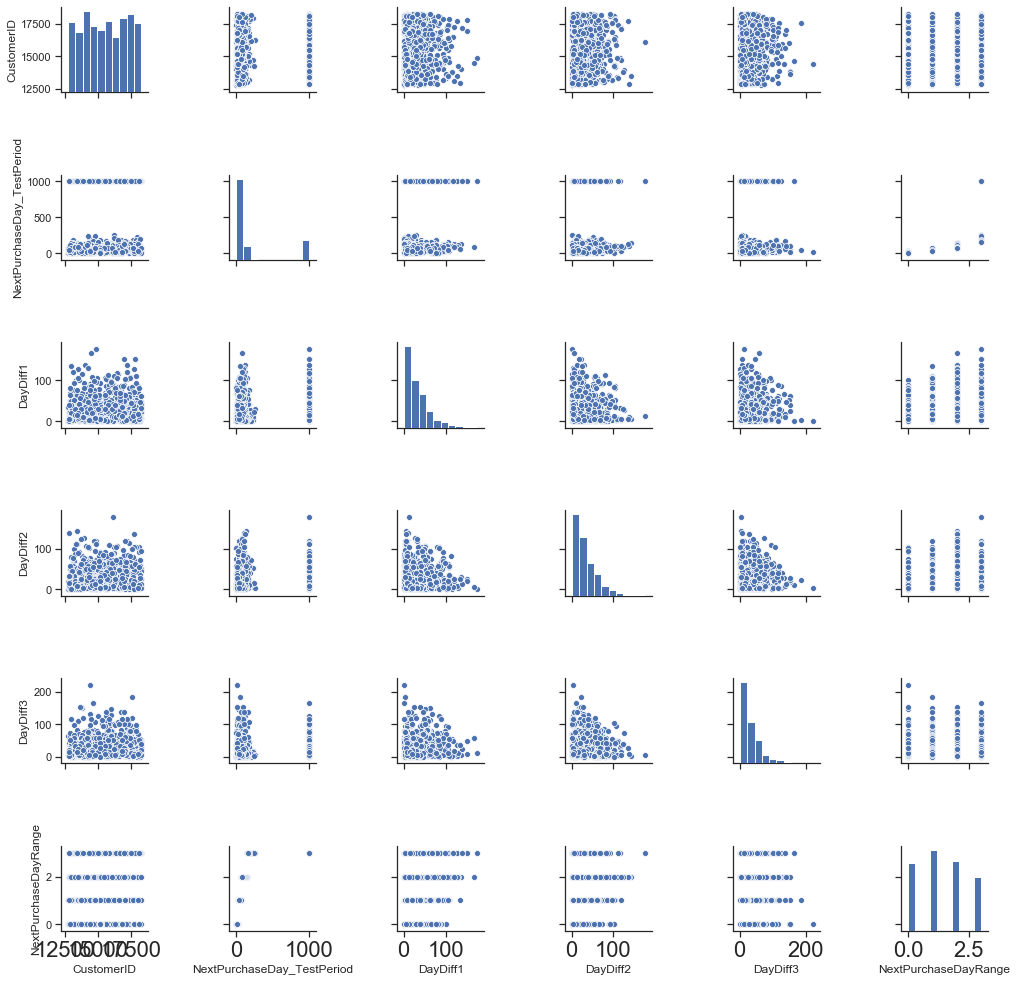

In [309]:
sns.pairplot(data)

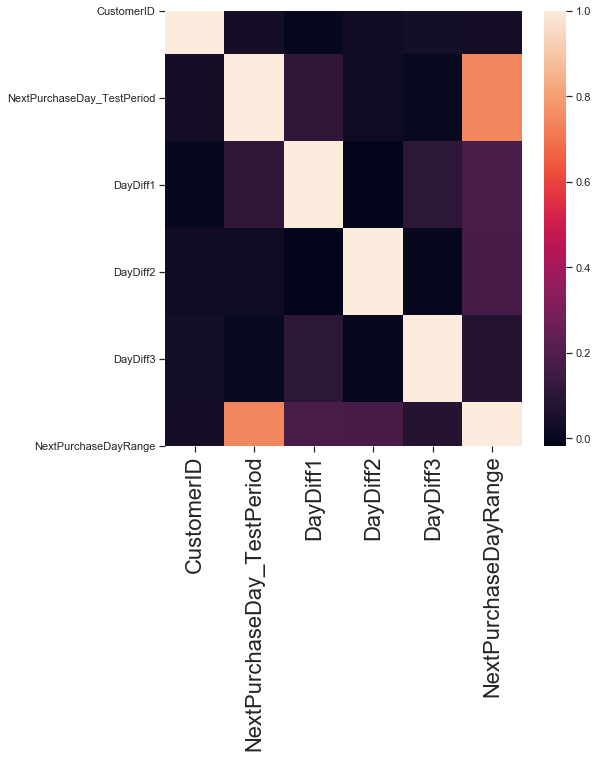

In [310]:
plt.figure(figsize=(8,8))
sns.heatmap(data.corr())

In [433]:
data['Average']=(data.DayDiff1+data.DayDiff2+data.DayDiff3)/3

In [434]:
data['Log']=np.log(data['Average'])

In [435]:
#data['Sin']=np.sin( data["Average"] )

In [436]:
X=data[['CustomerID','DayDiff1','DayDiff2','DayDiff3','Average','Log']]
y=data['NextPurchaseDayRange']

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [443]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
print('Training Score: ',clf.score(X_train,y_train))
print('Test Score: ',clf.score(X_test,y_test))

Training Score:  1.0
Test Score:  0.3269230769230769


In [444]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
print('Training Score: ',model.score(X_train,y_train))
print('Test Score: ',model.score(X_test,y_test))

Training Score:  0.9790660225442834
Test Score:  0.33974358974358976


In [446]:
np.random.seed(0)
clf1 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
clf2 = KNeighborsClassifier(n_neighbors = 1)    

bagging1 = BaggingClassifier(
    base_estimator = clf1,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)
bagging2 = BaggingClassifier(
    base_estimator = clf2,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)

In [448]:
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]
for clf, label in zip(clf_list, label):        
    scores = cross_val_score(clf, X_train, y_train, cv = 3, scoring = 'accuracy')
    print('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))
        
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))
    

Accuracy: 0.36 (+/- 0.00) [Decision Tree]
0.34615384615384615
Accuracy: 0.26 (+/- 0.02) [K-NN]
0.3141025641025641
Accuracy: 0.41 (+/- 0.03) [Bagging Tree]
0.3974358974358974
Accuracy: 0.29 (+/- 0.01) [Bagging K-NN]
0.26282051282051283


In [438]:
kfold = KFold(n_splits = 10, random_state = 7)
cart = DecisionTreeClassifier()
cart.fit(X_train, y_train)
results = cross_val_score(cart, X_train, y_train, cv = kfold)
print('Decision Tree, Cross-Validation mean: %.4f' % results.mean())

Decision Tree, Cross-Validation mean: 0.3204


In [439]:
print('Training Score: ',cart.score(X_train,y_train))
print('Test Score: ',cart.score(X_test,y_test))

Training Score:  1.0
Test Score:  0.3525641025641026


In [453]:
num_trees = 10
model1 = BaggingClassifier(base_estimator = clf1, n_estimators = num_trees, random_state = 7)
model1.fit(X_train, y_train)
results = cross_val_score(model1, X_train, y_train, cv = kfold)
print('Bagging, Cross-Validation mean: %.4f' % results.mean())

Bagging, Cross-Validation mean: 0.3671


In [454]:
print('Training Score: ',model1.score(X_train,y_train))
print('Test Score: ',model1.score(X_test,y_test))

Training Score:  0.42995169082125606
Test Score:  0.358974358974359


# Generating the Base First Level Models
The first level classification models can all be conveniently invoked via the Scikit-Learn library and are listed as follows:

Random Forest classifier

Extra Trees classifier

AdaBoost classifier

Gradient Boosting classifier

Support Vector classifier

# Parameters
A quick summary of the parameters:

n_jobs: Number of cores used for the training process. If set to -1, all cores are used.
n_estimators: Number of classification trees in your learning model (set to 10 per default).
max_depth: Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep.
verbose: Controls whether to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.
Please check out the full description via the official Scikit-Learn website.

In [343]:
# Set the parameters for the classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
#     'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
#     'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
#     'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In the code below, a class `SklearnHelper` allows to extend the inbuilt methods (such as train, predict and fit) common to all the `Scikit-Learn` classifiers. This cuts out redundancy as it avoids to write the same methods many times when invoking many different classifiers.

In [344]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS, random_state = SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed = 0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)

    def predict(self, X_test):
        return self.clf.predict(X_test)
    
    def fit(self, X_train, y_train):
        return self.clf.fit(X_train, y_train)
    
    def feature_importances(self, X_train, y_train):
        return self.clf.fit(X_train, y_train).feature_importances_

In [345]:
rf  = SklearnHelper(clf = RandomForestClassifier,     seed = SEED, params = rf_params)
et  = SklearnHelper(clf = ExtraTreesClassifier,       seed = SEED, params = et_params)
ada = SklearnHelper(clf = AdaBoostClassifier,         seed = SEED, params = ada_params)
gb  = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params = gb_params)
svc = SklearnHelper(clf = SVC,                        seed = SEED, params = svc_params)

# Out-of-Fold Predictions
Stacking uses predictions of base classifiers as input for training to a second level model.

However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second level training.

This runs the risk of the base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [348]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    #print(oof_train)
    oof_test = np.zeros((ntest, ))
    #print(oof_train)
    oof_test_skf = np.empty((NFOLDS, ntest))
    #print(oof_test_skf)
    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        #global test_train_index
        #test_train_index=train_index
        #print(train_index)
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis = 0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [349]:
# Create the objects that represent our the models
rf  = SklearnHelper(clf = RandomForestClassifier,     seed = SEED, params = rf_params)
et  = SklearnHelper(clf = ExtraTreesClassifier,       seed = SEED, params = et_params)
ada = SklearnHelper(clf = AdaBoostClassifier,         seed = SEED, params = ada_params)
gb  = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params = gb_params)
svc = SklearnHelper(clf = SVC,                        seed = SEED, params = svc_params)

In [350]:
y_train_array = y_train.values
x_train_array = X_train.values
x_test_array = X_test.values

In [351]:
# Create our OOF (Out-of-Fold) train and test predictions
# These base results will be used as new features
et_oof_train,  et_oof_test  = get_oof(et,  x_train_array, y_train_array, x_test_array) # Extra Trees
rf_oof_train,  rf_oof_test  = get_oof(rf,  x_train_array, y_train_array, x_test_array) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train_array, y_train_array, x_test_array) # AdaBoost 
gb_oof_train,  gb_oof_test  = get_oof(gb,  x_train_array, y_train_array, x_test_array) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train_array, y_train_array, x_test_array) # Support Vector Classifier

print('Training is complete')

Training is complete


# Feature importance from the different classifiers
The importance of the various features in the training and test sets is available from the first level classifiers with one very simple line of code.

As per the Scikit-Learn documentation, most of the classifiers are built in with an attribute which returns feature importances by refering to the .featureimportances_ attribute.

NOTE: SVC does not have the .featureimportances_ attribute.

In [352]:
# Create a dataframe with features
cols = X_train.columns.values
feature_dataframe = pd.DataFrame({
    'Feature':        cols,
    'Random Forest':  rf.feature_importances(x_train_array, y_train_array),
    'Extra Trees':    et.feature_importances(x_train_array, y_train_array),
    'AdaBoost':       ada.feature_importances(x_train_array, y_train_array),
    'Gradient Boost': gb.feature_importances(x_train_array, y_train_array)
})

In [353]:
feature_dataframe

Feature  Random Forest  Extra Trees  AdaBoost  Gradient Boost
0  CustomerID       0.156042     0.119242     0.254        0.264584
1    DayDiff1       0.170855     0.177584     0.226        0.201302
2    DayDiff2       0.168718     0.177867     0.204        0.171925
3    DayDiff3       0.154368     0.120727     0.140        0.154419
4     Average       0.172110     0.200073     0.100        0.111882
5         Log       0.177906     0.204507     0.076        0.095887

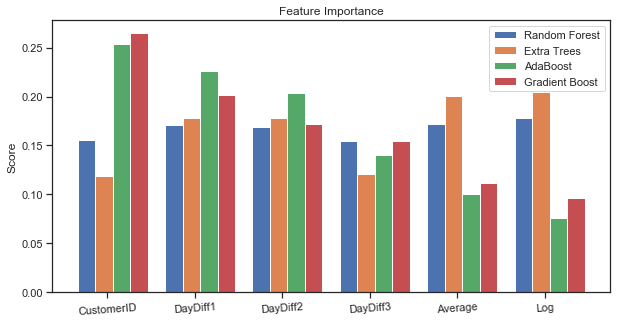

In [354]:
fig = plt.figure(figsize = (10, 5))

ind = np.arange(len(cols)) 
width = 0.2

for i, m in enumerate(feature_dataframe.columns[1:]):
    plt.bar(ind + ((i - 1 - width) * width), feature_dataframe[m], width, label = m)
    
plt.title('Feature Importance')
plt.xticks(ind, cols, rotation = 4)
plt.ylabel('Score')
plt.legend()
plt.show()

In [355]:
# Create a new column containing the average of values
feature_dataframe['Mean'] = feature_dataframe.mean(axis = 1) # axis = 1 computes the mean row-wise
feature_dataframe

Feature  Random Forest  Extra Trees  AdaBoost  Gradient Boost      Mean
0  CustomerID       0.156042     0.119242     0.254        0.264584  0.198467
1    DayDiff1       0.170855     0.177584     0.226        0.201302  0.193935
2    DayDiff2       0.168718     0.177867     0.204        0.171925  0.180627
3    DayDiff3       0.154368     0.120727     0.140        0.154419  0.142379
4     Average       0.172110     0.200073     0.100        0.111882  0.146016
5         Log       0.177906     0.204507     0.076        0.095887  0.138575

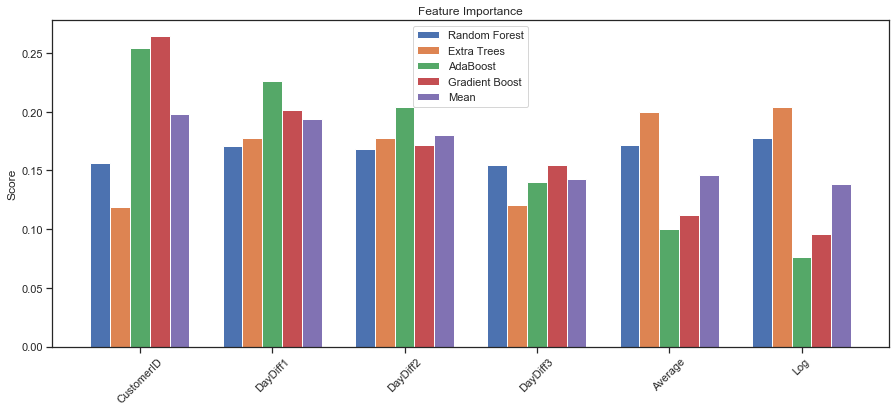

In [356]:
fig = plt.figure(figsize = (15, 6))

ind = np.arange(len(cols)) 
width = 0.15

for i, m in enumerate(feature_dataframe.columns[1:]):
    plt.bar(ind + ((i - 2) * width), feature_dataframe[m], width, label = m)

plt.title('Feature Importance')
plt.xticks(ind, cols, rotation = 45)
plt.ylabel('Score')
plt.legend()
plt.show()

In [357]:
def show_summary_report(actual, prediction):
    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)
    accuracy_ = accuracy_score(actual, prediction)
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    mat = confusion_matrix(actual, prediction)
    
    ax = plt.axes()
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('True label')
    ax.set_ylabel('Predicted label')
    ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
    plt.show()
    return (accuracy_)

*****************
* Random Forest *
*****************
Accuracy : 0.6200 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


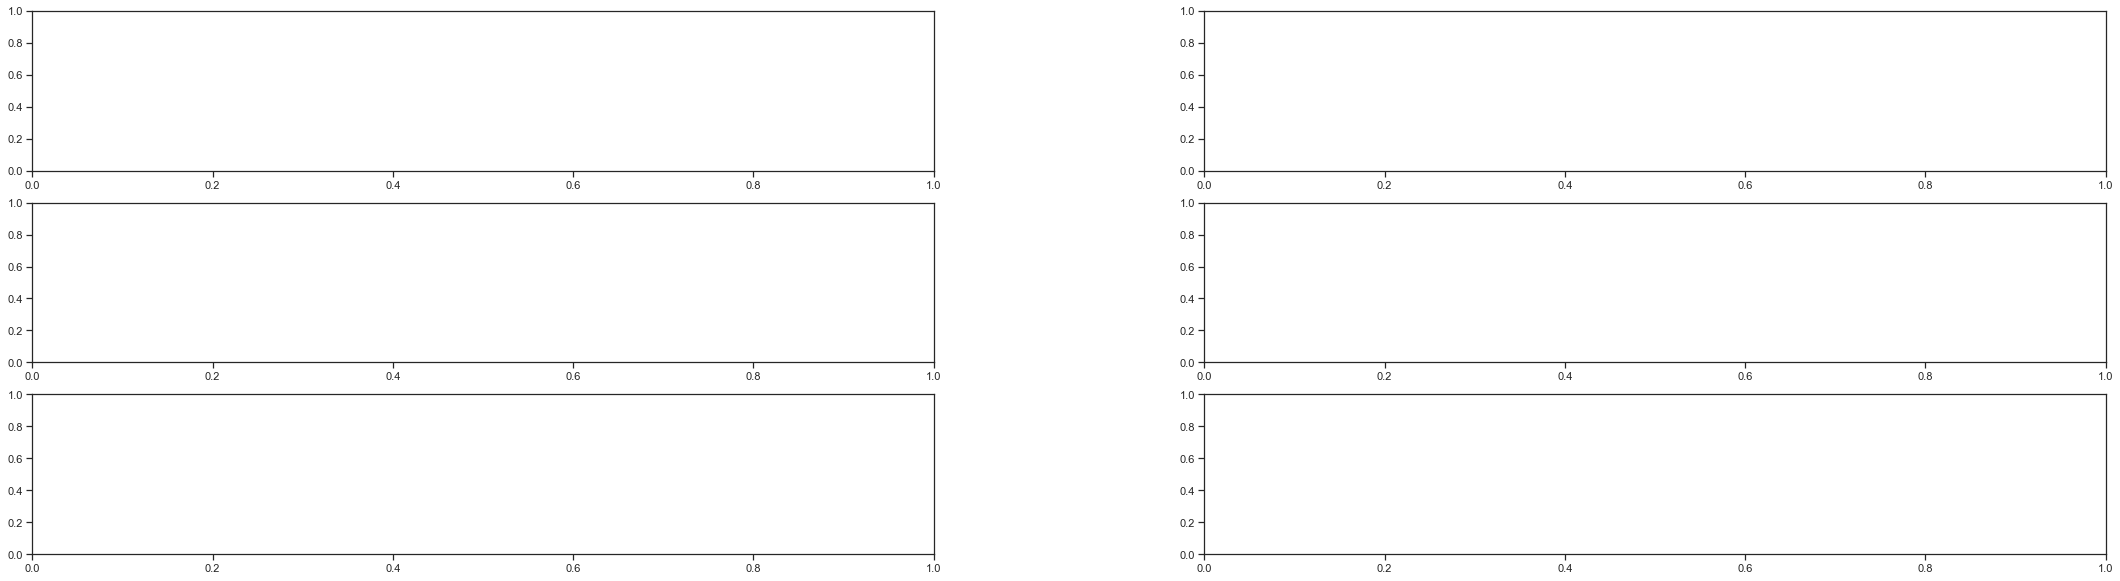

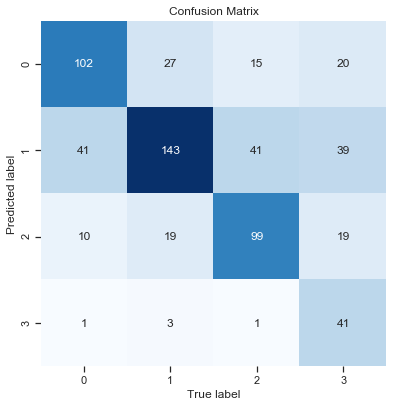


***************
* Extra Trees *
***************
Accuracy : 0.7021 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


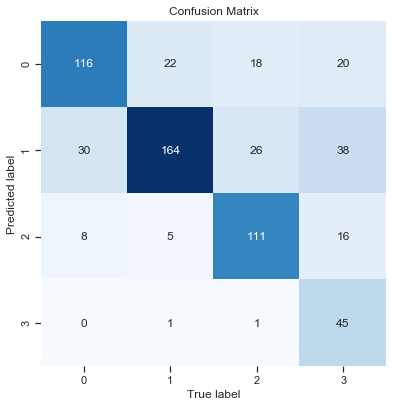


************
* AdaBoost *
************
Accuracy : 0.5008 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


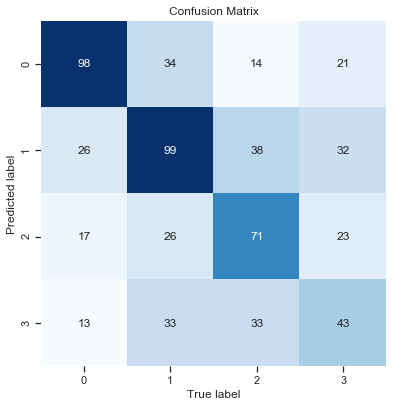


******************
* Gradient Boost *
******************
Accuracy : 1.0000 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


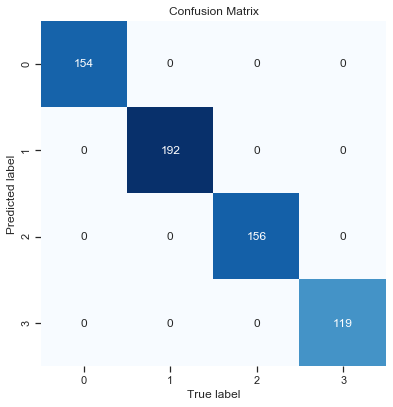


*****************************
* Support Vector Classifier *
*****************************
Accuracy : 0.3816 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


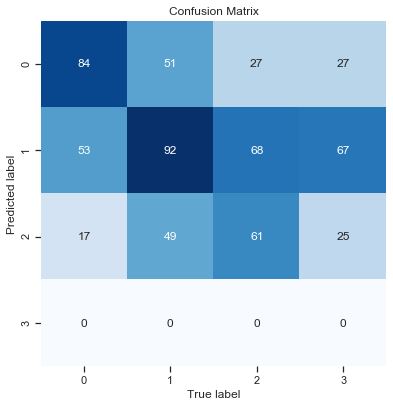

In [358]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy'])
fig, ax = plt.subplots(3, 2, figsize = (30,10))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)

models = ['Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boost', 'Support Vector Classifier']
for i, m in enumerate([rf, et, ada, gb, svc]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    predictions = m.predict(x_train_array)
    fig, ax = plt.subplots(3, 2, figsize = (5,10))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)
    # show the report
    accuracy_= show_summary_report(y_train_array, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_}
    print()

# Second Level Predictions from the First Level Output
First level output as new features
One can think of building a new set of features from the first level predictions to be used as training data for the next classifier.

The code below have the first level predictions from the earlier classifiers as new columns and trains the next classifier from those.

In [ ]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(),
    'ExtraTrees': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel()
})
print('Rows: %d, Columns: %d' % base_predictions_train.shape)
base_predictions_train.head()

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize = (10, 20))
plt.title('Correlation Heatmap of the Second Level Training set', size = 15)
sns.heatmap(base_predictions_train.astype(float).corr(),
            linewidths = 0.1,
            vmax = 1.0,
            square = True,
            cmap = colormap,
            linecolor = 'white',
            annot = True)
plt.show()

In [361]:
# Creates a new set of training and test data from the previous results results
xx_train = np.concatenate(
    (et_oof_train,
     rf_oof_train,
     ada_oof_train,
     gb_oof_train,
     svc_oof_train),
    axis = 1)
xx_test = np.concatenate(
    (et_oof_test,
     rf_oof_test,
     ada_oof_test,
     gb_oof_test,
     svc_oof_test),
    axis = 1)

# Second Level learning model via XGBoost
The XGBoost was built to optimize large-scale boosted tree algorithms.

The XGBoost parameters used in the model:

max_depth: How deep to grow the tree. Runs the risk of overfitting if set to too high.
gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
eta: Step size shrinkage used in each boosting step to prevent overfitting.

In [362]:
gbm = xgb.XGBClassifier(
#     learning_rate = 0.02,
    n_estimators = 2000,
    max_depth = 4,
    min_child_weight = 2,
#     gamma = 1,
    gamma = 0.9,                        
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = -1,
    scale_pos_weight = 1)

In [363]:
gbm.fit(xx_train, y_train)
predictions = gbm.predict(xx_train)

Accuracy : 0.6490 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


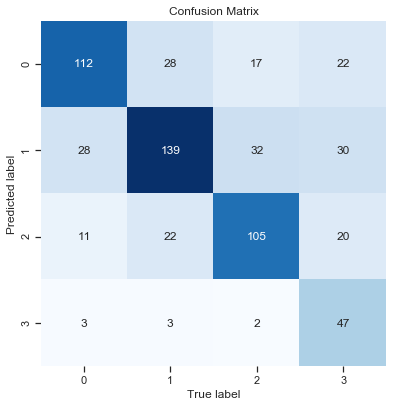

In [364]:
fig, ax = plt.subplots(3, 2, figsize = (5,10))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)
accuracy_ = show_summary_report(y_train, predictions)
# keep the results

results.loc[len(results)] = {
    'Model': 'XGBoost', 
    'Accuracy': accuracy_}
print()

In [365]:
results

Model  Accuracy
0              Random Forest  0.619968
1                Extra Trees  0.702093
2                   AdaBoost  0.500805
3             Gradient Boost  1.000000
4  Support Vector Classifier  0.381643
5                    XGBoost  0.648953

*****************
* Random Forest *
*****************
Accuracy : 0.3782 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


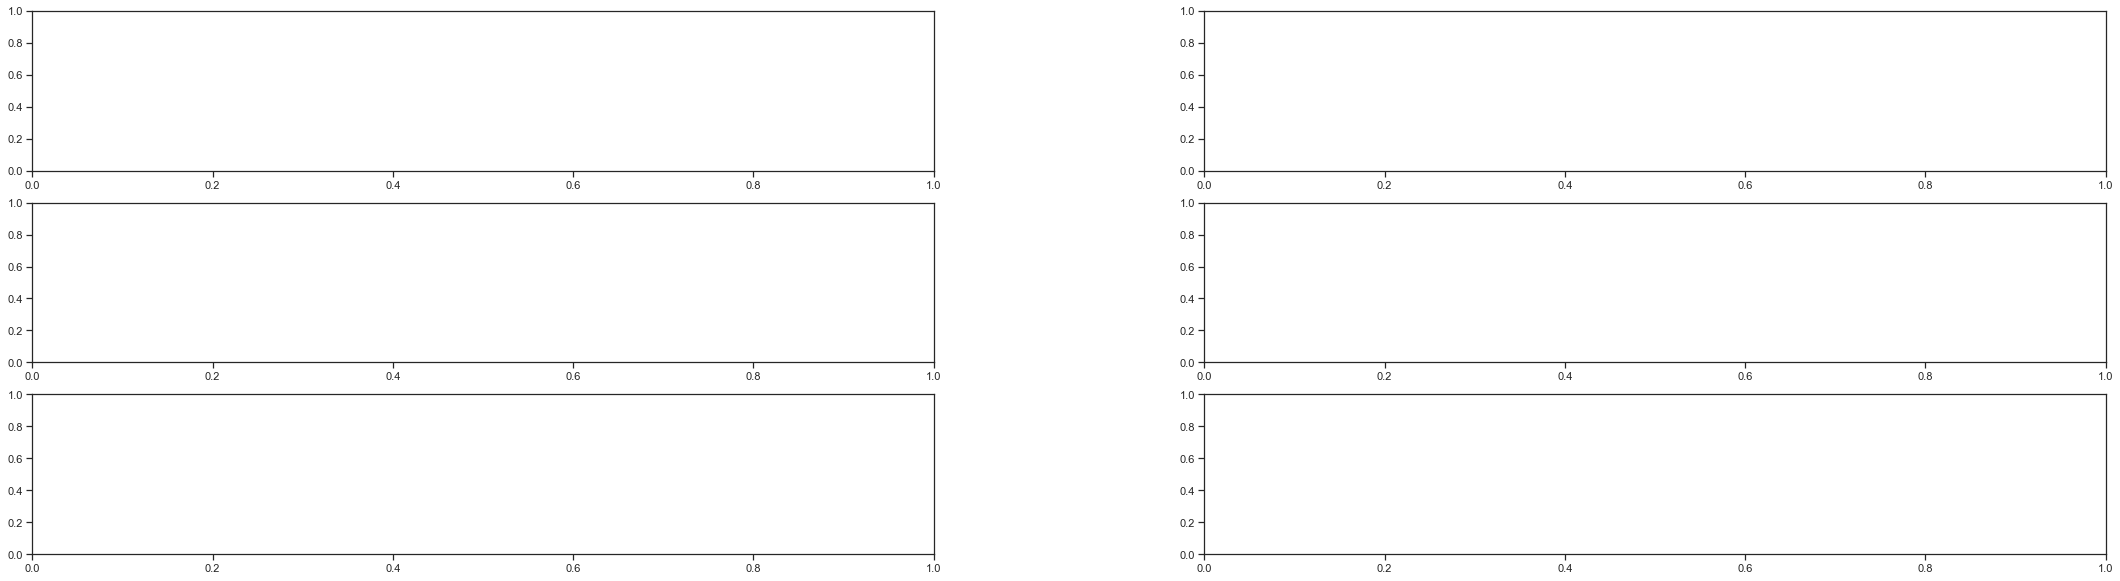

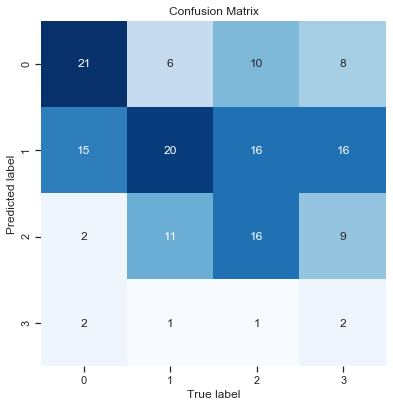


***************
* Extra Trees *
***************
Accuracy : 0.3397 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


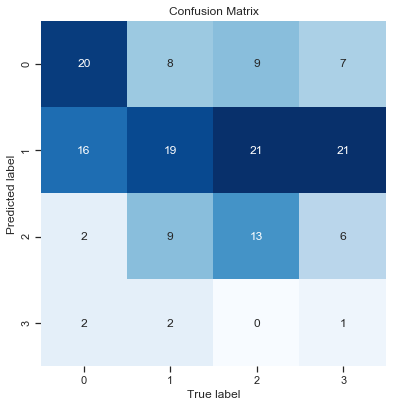


************
* AdaBoost *
************
Accuracy : 0.3526 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


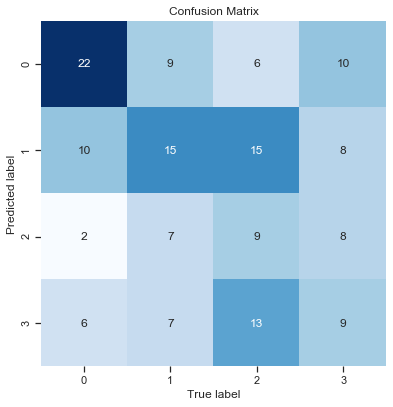


******************
* Gradient Boost *
******************
Accuracy : 0.3462 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


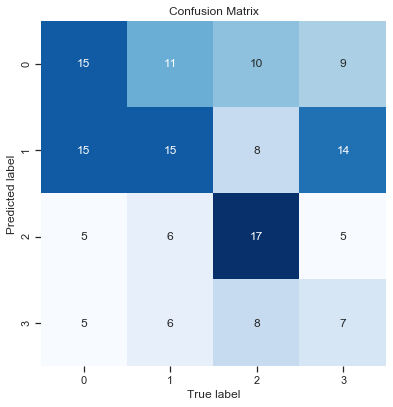


*****************************
* Support Vector Classifier *
*****************************
Accuracy : 0.3654 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


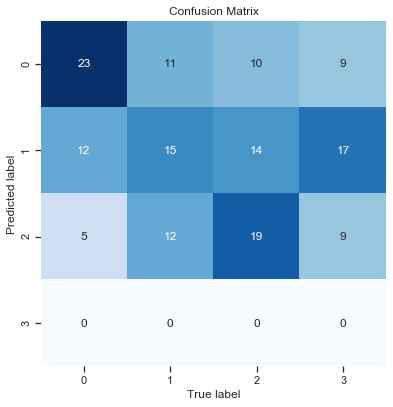

In [387]:
# Keep the results in a dataframe
results_Test = pd.DataFrame(columns = ['Model', 'Accuracy'])
fig, ax = plt.subplots(3, 2, figsize = (30,10))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)

models = ['Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boost', 'Support Vector Classifier']
for i, m in enumerate([rf, et, ada, gb, svc]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    predictions = m.predict(x_test_array)
    fig, ax = plt.subplots(3, 2, figsize = (5,10))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)
    # show the report
    accuracy_= show_summary_report(y_test, predictions)
    results_Test.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_}
    print()

In [388]:
predictions = gbm.predict(xx_test)

Accuracy : 0.3718 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


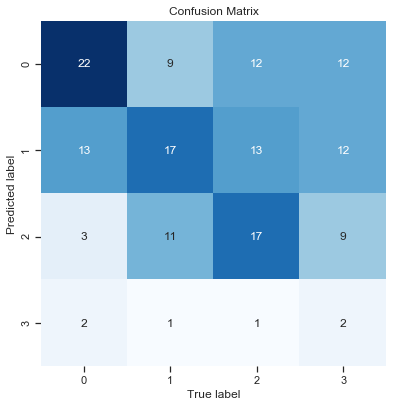

In [389]:
fig, ax = plt.subplots(3, 2, figsize = (5,10))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)
accuracy_ = show_summary_report(y_test, predictions)
results_Test.loc[len(results_Test)]={
    'Model': 'XGBoost', 
    'Accuracy': accuracy_}

In [390]:
results_Test

Model  Accuracy
0              Random Forest  0.378205
1                Extra Trees  0.339744
2                   AdaBoost  0.352564
3             Gradient Boost  0.346154
4  Support Vector Classifier  0.365385
5                    XGBoost  0.371795

In [370]:
data

CustomerID  NextPurchaseDay_TestPeriod  InvoiceDay  DayDiff1  DayDiff2  \
0       13047.0                        46.0  2011-07-08      19.0       4.0   
1       15100.0                       999.0  2011-01-13       3.0      25.0   
2       15291.0                        77.0  2011-06-20       8.0      67.0   
3       14688.0                        12.0  2011-07-21       9.0      14.0   
4       17809.0                        43.0  2011-07-18      24.0       4.0   
..          ...                         ...         ...       ...       ...   
772     17651.0                        76.0  2011-07-19      12.0      14.0   
773     14808.0                        69.0  2011-07-18       8.0      14.0   
774     12830.0                        42.0  2011-07-28       7.0      15.0   
775     13420.0                       999.0  2011-07-28      15.0       7.0   
776     17997.0                        34.0  2011-07-29      19.0       4.0   

     DayDiff3  NextPurchaseDayRange    Average       Log  
0        42.0                     1  21.666667  3.075775  
1         8.0                     3  12.000000  2.484907  
2         5.0                     2  26.666667  3.283414  
3        15.0                     0  12.666667  2.538974  
4        45.0                     1  24.333333  3.191847  
..        ...                   ...        ...       ...  
772       3.0                     2   9.666667  2.268684  
773       6.0                     1   9.333333  2.233592  
774      15.0                     1  12.333333  2.512306  
775      14.0                     3  12.000000  2.484907  
776       8.0                     1  10.333333  2.335375  

[777 rows x 9 columns]

In [371]:
data=pd.merge(data, customer[['CustomerID','Cluster']],on='CustomerID',how='left')

In [384]:
plot_frequency=data[data['Cluster']>1]

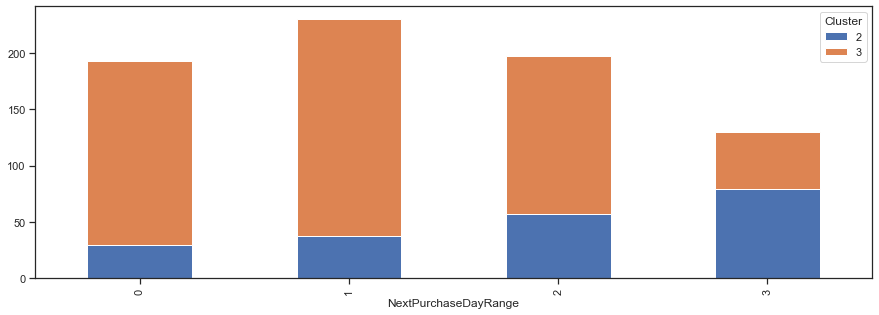

In [386]:
plot_frequency.groupby(['NextPurchaseDayRange', 'Cluster']).size().unstack().plot(kind='bar', stacked=True, figsize=(15, 5))